# ПРОЕКТ 📊

# 🔍 РЕШЕНИЕ ЗАДАЧИ КЛАССИФИКАЦИИ ПО ДИАПАЗОНУ ДАТ И ЗНАЧЕНИЙ 🔎

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li>
        <li><span><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование датасета</a></span></li>
        <li><span><span class="toc-item-num">3&nbsp;&nbsp;</span>Визуализация данных</a></span></li>
        <li><span><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li>
        <li><span><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод по исследованию</a></span></li>
    </ul>

# 📝 Описание проекта:  

<div style="border:solid green 3px; padding: 20px">
    
В рамках проекта мы исследуем датасет с массивами дат и соответствующих значений к ним. Обучим модели, вычислим метрики и визуализируем выходные данные. По окончании проекта сделаем общий вывод.

# 📂 Описание данных:

<div style="border:solid green 3px; padding: 20px">

Нам даны датасеты trаin.pаrquet и tеst.pаrquet с данными для последующего исследования и обработки.

# 🎯 Цель проекта:

<div style="border:solid green 3px; padding: 20px">
    
Провести анализ и обработку предоставленных данных, построить и проверить гипотезы, обучить модели с использованием метрики ROC AUC для оценки производительности и сделать обобщающий вывод.

# 📅 План действий:

<div style="border:solid green 3px; padding: 20px">

1. Загрузить все необходимые для проекта библиотеки;
2. Исследовать и описать датасеты;
3. Провести анализ, сгенерировать признаки;
4. Обучить модель и рассчитать метрики качества;
5. Провести визуализацию полученных данных;
6. Сделать вывод по результатам исследования.

## Загрузка данных

<div style="border:solid green 2px; padding: 5px">
    
    💬 установим необходимые библиотеки для работы с датасетами и моделями:

In [47]:
!pip install pyarrow -q
!pip install fastparquet -q
!pip install keras -q
!pip install tensorflow -q
!pip install dask[dataframe]

<div style="border:solid green 2px; padding: 5px">
    
    💬 импортируем необходимые библиотеки, зафиксируем RS:

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, KFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

RS = 42

<div style="border:solid green 2px; padding: 5px">

    💬 выгружаем датасет и сохраняем его в переменную:

In [79]:
df_train = pd.read_parquet("https://github.com/glumov-d/glumov-d.github.io/raw/refs/heads/main/demonstration-project/train.parquet")
df_test = pd.read_parquet("https://github.com/glumov-d/glumov-d.github.io/raw/refs/heads/main/demonstration-project/test.parquet")

<div style="border:solid green 2px; padding: 5px">
    
    💬 посмотрим на начинку наших файлов:

In [50]:
df_train.info()
print()
display(df_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB



,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


<div style="border:solid green 2px; padding: 5px">
    
    💡 что видим: тренировочный датасет состоит из 80 тысяч строк, видим массивы значений дат и
    соответствующих величин к ним, видим лейблы к каждой строке; в строках нет нулевых значений;
    даты идут друг за другом с периодичностью в один месяц, values могут быть как положительные,
    так и отрицательные;
    
    💬 теперь очередь за тестовой выборкой:

In [51]:
df_test.info()
print()
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB



,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


<div style="border:solid green 2px; padding: 5px">
    
    💡 что видим: аналогичный массив данных, что и в тренировочной выборке, но уже без лейблов
    и в количестве 20 тысяч; на этой выборке мы будем тестировать нашу модель.
    
    💬 проверим, все ли даты идут строго друг за другом или есть пропуски в датах, построим функцию:

In [52]:
def check_dates(dates):
    for i in range(1, len(dates)):
        current_year, current_month = dates[i].year, dates[i].month
        previous_year, previous_month = dates[i - 1].year, dates[i - 1].month

        if (current_year == previous_year and current_month != previous_month + 1) or \
           (current_year == previous_year + 1 and current_month != 1) or \
           (current_year > previous_year + 1):
            return False
    return True

dates_check = df_train['dates'].apply(check_dates)

dates_check_count = dates_check.value_counts().get(False, 0)

print(f'Количество списков с непоследовательными датами: {dates_check_count}')

Количество списков с непоследовательными датами: 0


<div style="border:solid green 2px; padding: 5px">
    
    💡 видим, что даты упорядочены правильно и предобработки не требуют
    
    💬 проверим, есть ли пропуски в values:

In [53]:
def count_nan_lists(values):
      return values.apply(lambda x: any(pd.isna(x)))

nan_check = count_nan_lists(df_train['values'])
nan_count = nan_check.sum()

print(f"Общее количество списков с NaN: {nan_count}")

Общее количество списков с NaN: 88


<div style="border:solid green 2px; padding: 5px">
    
    💡 видим, что количество пропусков есть в 88 списках из 80000; количество незначительно и не
    повлияет на качество результатов, если удалить данные, или заполнить, например, средними значениями
    
    💬 также можно посмотреть, как наши величины изменяются со временем на примере нескольких
    случайных строк, для наглядности, чтобы не нагружать график:

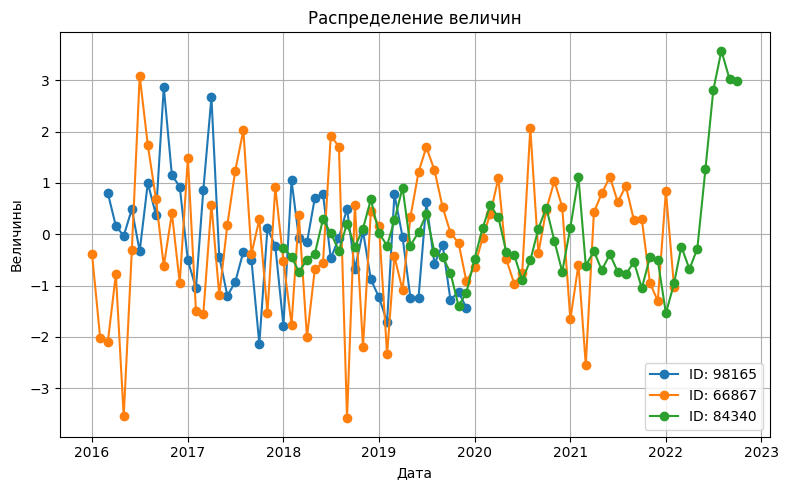

In [54]:
df_visual = df_train.sample(3).copy()
df_visual['dates'] = df_visual['dates'].apply(lambda x: pd.to_datetime(x))

plt.figure(figsize=(8, 5))

for index, row in df_visual.iterrows():
    plt.plot(row['dates'], row['values'], marker='o', label=f'ID: {row["id"]}')

plt.title('Распределение величин')
plt.xlabel('Дата')
plt.ylabel('Величины')
plt.xticks()
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<div style="border:solid green 2px; padding: 5px">
    
    💡 из небольшой визуализации можем сделать вывод, что разные id могут вести себя по-разному:
    плавные или резкие колебания, также можно отметить разнонаправленность изменения величин
    
    💬 а что, если загрузить 500 строчек и посмотреть, есть ли какие-то тенденции или тренды:

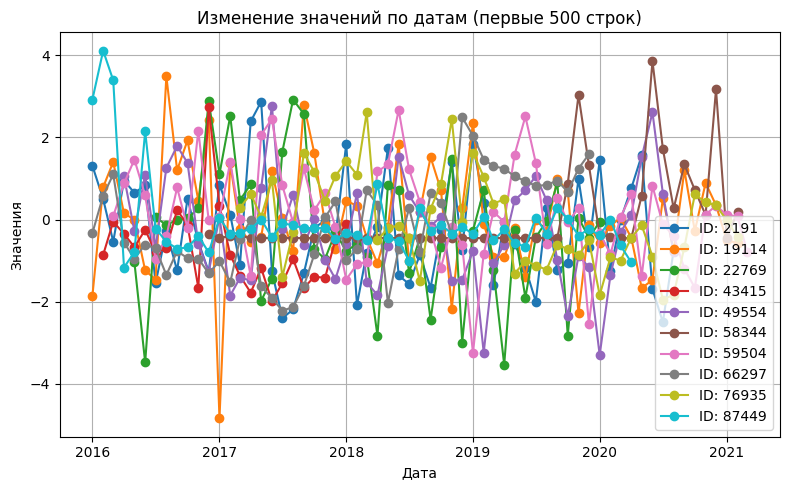

In [55]:
df_exploded = df_train.explode(['dates', 'values'])
df_exploded['dates'] = pd.to_datetime(df_exploded['dates'])

df_subset = df_exploded.head(500)

plt.figure(figsize=(8, 5))

for id_value, group in df_subset.groupby('id'):
    plt.plot(group['dates'], group['values'], marker='o', label=f'ID: {id_value}')

plt.title('Изменение значений по датам (первые 500 строк)')
plt.xlabel('Дата')
plt.ylabel('Значения')
plt.xticks()
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<div style="border:solid green 2px; padding: 5px">
    
    💡 по размеру величин в разные даты видим широкий разброс, делаем вывод, что размер value от даты
    не зависит, а есть ли тенденции и тренды поможет определить декомпозиция временного ряда
    
    💬 декомпозируем временный ряд трёх случайных id и построим для них коррелограммы,
    чтобы оценить автокорреляцию остатков:

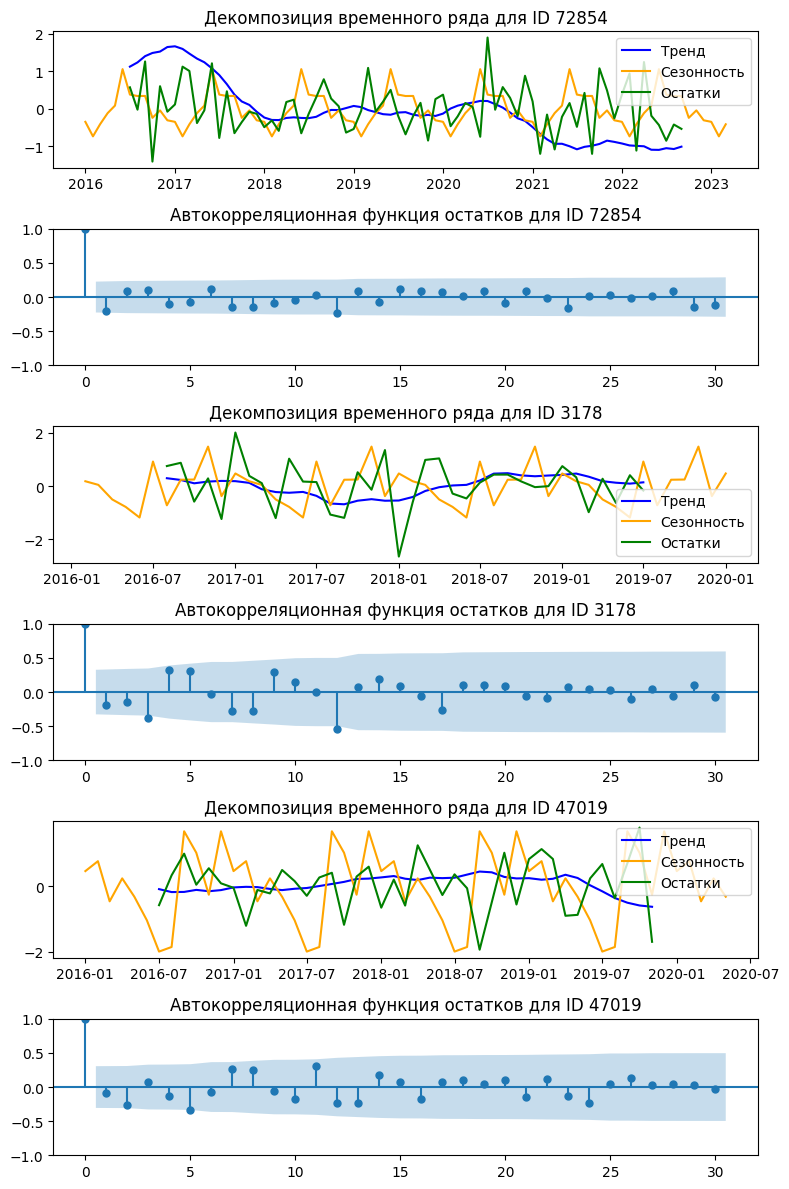

In [56]:
df_ids = df_exploded['id'].sample(3).values

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 12))

for i, df_id in enumerate(df_ids):

    data_analysis = df_exploded[df_exploded['id'] == df_id].set_index('dates')

    decomposition = seasonal_decompose(data_analysis['values'], model='additive')

    axes[i * 2].plot(decomposition.trend, label='Тренд', color='blue')
    axes[i * 2].plot(decomposition.seasonal, label='Сезонность', color='orange')
    axes[i * 2].plot(decomposition.resid, label='Остатки', color='green')
    axes[i * 2].set_title(f'Декомпозиция временного ряда для ID {df_id}', fontsize=12)
    axes[i * 2].legend()

    residual = decomposition.resid.dropna()

    plot_acf(residual, lags=30, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'Автокорреляционная функция остатков для ID {df_id}', fontsize=12)

plt.tight_layout()
plt.show()

<div style="border:solid green 2px; padding: 5px">
    
    💡 видим, что тренд может быть разнонаправленным, присутствует сезонность, а лаги в большинстве
    случаев входят в доверительный интервал, а значит, что модель адекватно описывает данные
    
    💬 проведём тест Дикки-Фуллера и проверим гипотезы на первых 500 строках;
    данный тест позволит нам проверить гипотезу, стационарны ли наши временные ряды:

In [57]:
result = adfuller(df_subset['values'])
print('значение ADF:', result[0])
print('p-value:', result[1])

значение ADF: -4.871024622282859
p-value: 3.969788428233331e-05


<div style="border:solid green 2px; padding: 5px">
    
    💡 отрицательное значение ADF даёт основания полагать, что наши временные ряды - стационарные;
    p-value 3.97 в -5 степени показывает крайне низкое число, что значительно меньше уровня
    значимости в 0.01, следовательно, мы отвергаем нулевую гипотезу, что ряд имеет единичный корень;
    поэтому есть все основания полагать, что наши временные ряды стационарны.
    
    💬 мы исследовали наши временные ряды, через гипотезы определили, что они стационарны, а значит,
    можно приступить к обучению моделей; так как выведенные из массивов данные увеличивают датасет
    до нескольких миллионов строк, воспользуемся усреднением данных каждого массива,
    так модель лучше интерпретирует соотнесение лейбла к связке дата-величина, поменяем тип данных:

In [58]:
df_train['dates'] = df_train['dates'].apply(lambda x: pd.to_datetime(x))

def calc_average(array):
    return array.mean()

df_train['average_date'] = df_train['dates'].apply(calc_average)
df_train['average_value'] = df_train['values'].apply(calc_average)

df_train.info()
print()
print(df_train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             80000 non-null  int64         
 1   dates          80000 non-null  object        
 2   values         80000 non-null  object        
 3   label          80000 non-null  float64       
 4   average_date   80000 non-null  datetime64[ns]
 5   average_value  79912 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.7+ MB

id                0
dates             0
values            0
label             0
average_date      0
average_value    88
dtype: int64


<div style="border:solid green 2px; padding: 5px">

    💬 заполняем пропуски медианой, так как она лучше работает со значениями, если есть выбросы:

In [59]:
df_train['average_value'] = df_train['average_value'].infer_objects().fillna(df_train['average_value'].median())
print(df_train.isna().sum())

id               0
dates            0
values           0
label            0
average_date     0
average_value    0
dtype: int64


<div style="border:solid green 2px; padding: 5px">

    💬 добавляем признаки месяца и года для лучшей прогнозируемости модели:

In [60]:
df_train['month'] = df_train['average_date'].dt.month
df_train['year'] = df_train['average_date'].dt.year

display(df_train.head(3))

,id,dates,values,label,average_date,average_value,month,year
0,19114,"DatetimeIndex(['2016-01-01', '2016-02-01', '20...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,2018-07-17 02:42:34.838709760,0.023710,7,2018
1,22769,"DatetimeIndex(['2016-05-01', '2016-06-01', '20...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,2018-03-02 01:04:00.000000000,-0.310777,3,2018
2,76935,"DatetimeIndex(['2017-03-01', '2017-04-01', '20...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,2019-02-15 02:00:00.000000000,-0.046042,2,2019


<div style="border:solid green 2px; padding: 5px">
    
    💬 выделяем признаки Х и у:  

In [61]:
X = df_train[['average_value', 'month', 'year']]
y = df_train['label']

<div style="border:solid green 2px; padding: 5px">
    
    💬 устраняем несбалансированность классов методом SMOTE и делим на выборки:

In [62]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

<div style="border:solid green 2px; padding: 5px">

    💬 обучим классификатор LGBM через кросс-валидацию:

In [64]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 100]
}

model_lg = LGBMClassifier(verbosity=-1)
grid_search = GridSearchCV(estimator=model_lg, param_grid=param_grid, scoring='roc_auc', cv=tscv)
grid_search.fit(X_train, y_train)

best_model_lg = grid_search.best_estimator_

print('Лучшие гиперпараметры:', grid_search.best_params_)
roc_auc = grid_search.best_score_
print(f'ROC_AUC: {roc_auc:.4f}')

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 50}
ROC_AUC: 0.8086
CPU times: user 2min 44s, sys: 1.76 s, total: 2min 46s
Wall time: 3min 16s


<div style="border:solid green 2px; padding: 5px">
    
    💬 обучим классификатор XGBoosting через кросс-валидацию:

In [65]:
%%time

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=tscv)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print('Лучшие гиперпараметры:', grid_search.best_params_)

roc_auc = grid_search.best_score_
print(f'ROC_AUC: {roc_auc:.4f}')

Лучшие гиперпараметры: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
ROC_AUC: 0.8083
CPU times: user 3min 31s, sys: 1.07 s, total: 3min 32s
Wall time: 2min 45s


<div style="border:solid green 2px; padding: 5px">
    
    💬 обучим нейросеть:

In [66]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

early_stopping = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7906 - loss: 0.5495 - val_AUC: 0.8017 - val_loss: 0.5396
Epoch 2/30
  98/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8037 - loss: 0.5372

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


2169/2169 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8031 - loss: 0.5364 - val_AUC: 0.8018 - val_loss: 0.5408
Epoch 3/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8030 - loss: 0.5362 - val_AUC: 0.8020 - val_loss: 0.5380
Epoch 4/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8060 - loss: 0.5328 - val_AUC: 0.8023 - val_loss: 0.5408
Epoch 5/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.8042 - loss: 0.5348 - val_AUC: 0.8026 - val_loss: 0.5379
Epoch 6/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.8068 - loss: 0.5313 - val_AUC: 0.8021 - val_loss: 0.5382
Epoch 7/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8036 - loss: 0.5345 - val_AUC: 0.8019 - val_loss: 0.5368
Epoch 8/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8064 - loss: 0.5312 - val_AUC: 0.8024 - val_loss: 0.5362
Epoch 9/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8062 - loss: 0.5318 - val_AUC: 0.8023 - val_loss: 0.5364
Epoch 10/30
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/s

<div style="border:solid green 2px; padding: 5px">

    💬 проверим модель на тестовой выборке, посмотрим матрицу ошибок и отчёт по метрикам качества:

In [67]:
model_lg.fit(X_train, y_train)
y_pred_proba = model_lg.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

roc_auc_test = roc_auc_score(y_test, y_pred_proba)
print('roc_auc на тестовой выборке:', roc_auc_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

roc_auc на тестовой выборке: 0.813259803322814
              precision    recall  f1-score   support

         0.0       0.74      0.71      0.72     14584
         1.0       0.71      0.75      0.73     14326

    accuracy                           0.73     28910
   macro avg       0.73      0.73      0.73     28910
weighted avg       0.73      0.73      0.73     28910

[[10303  4281]
 [ 3640 10686]]


<div style="border:solid green 2px; padding: 5px">

    💬 построим РОК-кривую нашей модели:

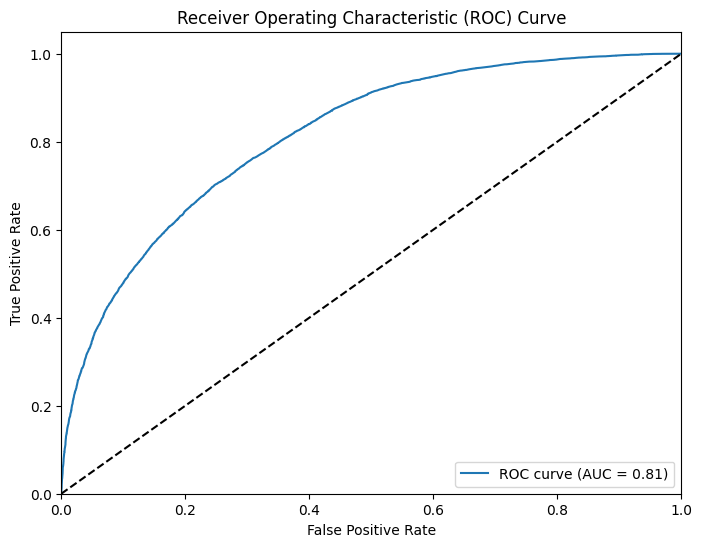

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<div style="border:solid green 2px; padding: 5px">

    💬 сохраняем в файл:

In [84]:
df_test['dates'] = df_test['dates'].apply(lambda x: pd.to_datetime(x))

def calc_average(array):
    return array.mean()

df_test['average_date'] = df_test['dates'].apply(calc_average)
df_test['average_value'] = df_test['values'].apply(calc_average)

df_test['month'] = df_test['average_date'].dt.month
df_test['year'] = df_test['average_date'].dt.year

features = ['average_value', 'month', 'year']
X_test = df_test[features]

predictions = model.predict(X_test)

if predictions.ndim > 1:
    predictions = predictions.flatten()

results = pd.DataFrame({
    'id': df_test['id'],
    'score': predictions
})

results.to_csv(r'C:\Users\DEMON\Downloads\submission.csv', index=False)

print("Предсказания сохранены в submission.csv")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Предсказания сохранены в submission.csv


<div style="border:solid green 4px; padding: 15px">

# ИТОГОВЫЙ ВЫВОД:

##1. Загрузка данных:
    
    а) Подгрузили необходимые библиотеки;
    
    б) Изучили датасеты;
    
    в) Провели предобработку;
    
##2. Провели визуализацию:
    
    а) Визуализировали даты и величины;
    
    б) Визуализировали тренды и сезонность;
    
    в) Визуализировали коррелограммы;
    
##3. Исследование:
    
    а) Изучили графики, сделали выводы;
    
    б) Провели тесты;
    
    в) Построили гипотезы;

##4. Обучение модели:

    а) Подобрали модели и подходящие гиперпараметры;
    
    б) Обучили модель на данных;
    
    в) Сделали вывод;

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">

# ЗАКЛЮЧЕНИЕ:

    Мы выбрали три модели для обучения, каждая из которых показала результат целевой метрики ROC_AUC
    80-81%, что означает, что все модели справились с обработкой величин и дат и спрогнозировали лейбл
    на хорошем уровне.

    Что можно улучшить:
    Можно было бы подобрать наиболее оптимальные гиперпараметры для модели или использовать данные
    без усреднения, однако ограниченные ресурсы сервера позволили обучиться только на текущих.